In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import torch
import pandas as pd
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(suppress=True)
from Utils import *

In [3]:
torch.cuda.set_device(1)

In [4]:
import sys
sys.path.insert(0, 'preprocess/')
import vectorizer

import pickle

In [5]:
vec = pickle.load(open('preprocess/IMDB/imdb_data.p', 'rb'))
add_frequencies(vec, vec.seq_text['train'])

In [6]:
import model.Attn_Word_Pert as M
Model = M.Model

In [7]:
X, Xt, Xr = vec.seq_text['train'], vec.seq_text['test'], vec.seq_text['rem']
y, yt, yr = vec.label['train'], vec.label['test'], vec.label['rem']

In [8]:
X, y = filterbylength(X, y, min_length=6)
Xt, yt = filterbylength(Xt, yt, min_length=6)
Xr, yr = filterbylength(Xr, yr, min_length=6)

Xt, yt = sortbylength(Xt, yt)
Xr, yr = sortbylength(Xr, yr)

In [9]:
pos_weight = 1 #len(y)/sum(y) - 1

In [15]:
from sklearn.metrics import classification_report, f1_score

def train(name='') :
    model = Model(vec.vocab_size, vec.word_dim, 64, dirname='imdb', hidden_size=128, pre_embed=vec.embeddings)
    best_f1 = 0.0
    for i in tqdm_notebook(range(10)) :
        loss = model.train(X, y)
        o, he = model.evaluate(Xt)
        o = np.array(o)
        rep = classification_report(yt, (o > 0.5))
        f1 = f1_score(yt, (o > 0.5), pos_label=1)
        print(rep)
        stmt = '%s, %s' % (i, loss)
        if f1 > best_f1 and i > 3:
            best_f1 = f1
            dirname = model.save_values(add_name=name, save_model=True)
            print("Model Saved", f1)
        else :
            dirname = model.save_values(add_name=name, save_model=False)
            print("Model not saved", f1)
        f = open(dirname + '/epoch.txt', 'a')
        f.write(stmt + '\n')
        f.write(rep + '\n')
        f.close()
    
    return model

In [16]:
train(name='first_final_imdb')

Setting Embedding


              precision    recall  f1-score   support

           0       0.86      0.92      0.89      2184
           1       0.91      0.85      0.88      2172

   micro avg       0.88      0.88      0.88      4356
   macro avg       0.89      0.88      0.88      4356
weighted avg       0.89      0.88      0.88      4356

Model not saved 0.8799809114769744


              precision    recall  f1-score   support

           0       0.93      0.86      0.90      2184
           1       0.87      0.94      0.90      2172

   micro avg       0.90      0.90      0.90      4356
   macro avg       0.90      0.90      0.90      4356
weighted avg       0.90      0.90      0.90      4356

Model not saved 0.9034116083296412


              precision    recall  f1-score   support

           0       0.87      0.93      0.90      2184
           1       0.93      0.86      0.89      2172

   micro avg       0.90      0.90      0.90      4356
   macro avg       0.90      0.90      0.90      4356
weighted avg       0.90      0.90      0.90      4356

Model not saved 0.8937186529734895


              precision    recall  f1-score   support

           0       0.93      0.87      0.89      2184
           1       0.87      0.93      0.90      2172

   micro avg       0.90      0.90      0.90      4356
   macro avg       0.90      0.90      0.90      4356
weighted avg       0.90      0.90      0.90      4356

Model not saved 0.9010695187165775


              precision    recall  f1-score   support

           0       0.91      0.87      0.89      2184
           1       0.88      0.91      0.89      2172

   micro avg       0.89      0.89      0.89      4356
   macro avg       0.89      0.89      0.89      4356
weighted avg       0.89      0.89      0.89      4356

Model Saved 0.8923076923076925


              precision    recall  f1-score   support

           0       0.88      0.91      0.89      2184
           1       0.90      0.88      0.89      2172

   micro avg       0.89      0.89      0.89      4356
   macro avg       0.89      0.89      0.89      4356
weighted avg       0.89      0.89      0.89      4356

Model not saved 0.8916841369671559


              precision    recall  f1-score   support

           0       0.89      0.88      0.88      2184
           1       0.88      0.89      0.89      2172

   micro avg       0.88      0.88      0.88      4356
   macro avg       0.88      0.88      0.88      4356
weighted avg       0.89      0.88      0.88      4356

Model not saved 0.8850126233647004


              precision    recall  f1-score   support

           0       0.89      0.89      0.89      2184
           1       0.89      0.89      0.89      2172

   micro avg       0.89      0.89      0.89      4356
   macro avg       0.89      0.89      0.89      4356
weighted avg       0.89      0.89      0.89      4356

Model not saved 0.8875576036866358


              precision    recall  f1-score   support

           0       0.88      0.91      0.89      2184
           1       0.90      0.88      0.89      2172

   micro avg       0.89      0.89      0.89      4356
   macro avg       0.89      0.89      0.89      4356
weighted avg       0.89      0.89      0.89      4356

Model not saved 0.8894601542416453


              precision    recall  f1-score   support

           0       0.92      0.85      0.89      2184
           1       0.86      0.93      0.89      2172

   micro avg       0.89      0.89      0.89      4356
   macro avg       0.89      0.89      0.89      4356
weighted avg       0.89      0.89      0.89      4356

Model Saved 0.8931823228958472



# **EVALUATION**

In [17]:
def load_model(dirname) :
    model = Model(vec.vocab_size, vec.word_dim, 32, dirname='imdb', hidden_size=128, pre_embed=vec.embeddings)
    model.dirname = dirname
    model.load_values(dirname)
    return model

In [18]:
model = load_model('outputs/attn_word_imdb/FriOct1918:40:062018_first_final_imdb/')

Setting Embedding


In [19]:
yt_hat, attn_hat = evaluate_and_print(model, Xt, yt)

              precision    recall  f1-score   support

           0       0.92      0.85      0.89      2184
           1       0.86      0.93      0.89      2172

   micro avg       0.89      0.89      0.89      4356
   macro avg       0.89      0.89      0.89      4356
weighted avg       0.89      0.89      0.89      4356



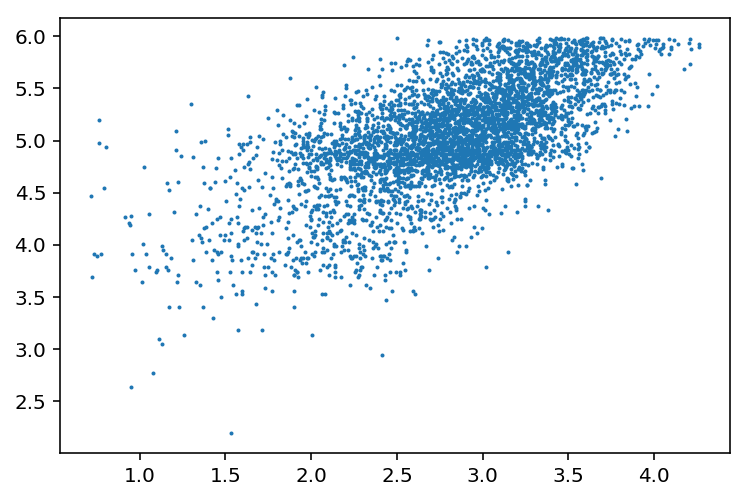

In [20]:
plot_entropy(Xt, attn_hat)

# __Sampling__

In [ ]:
model.vec = vec
sampled_output = model.sampling_top(Xt, sample_vocab=100, topnum=5)

In [39]:
import pickle
pickle.dump(sampled_output, open(model.dirname + '/sampled.p', 'wb'))

In [73]:
sampled_output = pickle.load(open(model.dirname + '/sampled.p', 'rb'))

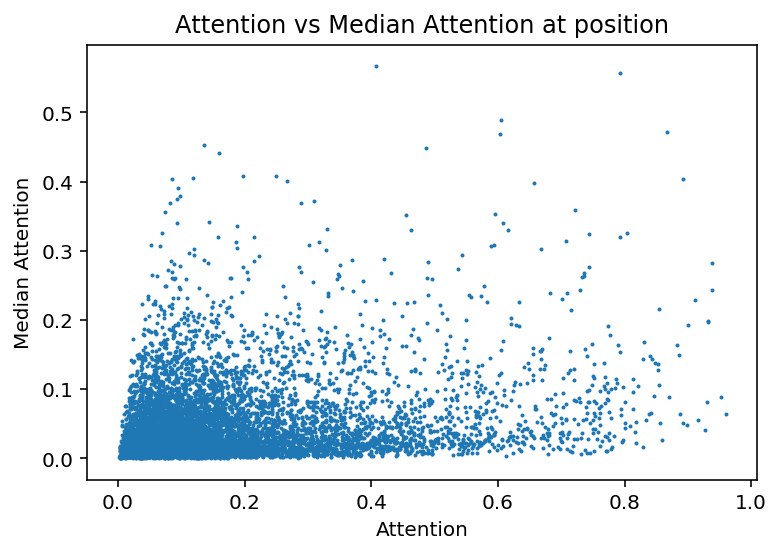

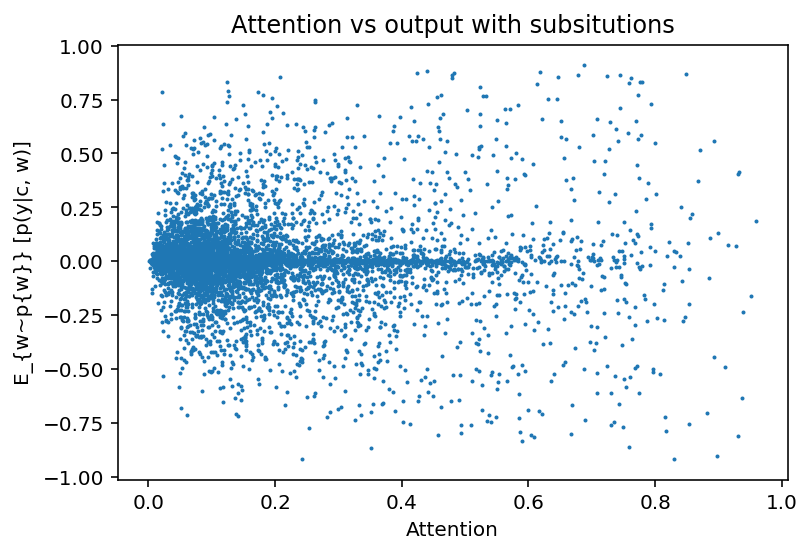

In [74]:
generate_medians_from_sampling_top(sampled_output, attn_hat, yt_hat, dirname=model.dirname)

In [75]:
distractors = get_distractors(sampled_output, attn_hat)
print_few_distractors(vec, Xt, attn_hat, sampled_output, distractors)

0.19880715705765406 1 503


--------------------


****************************************


In [66]:
print_attn(vec.map2words(Xt[1000]), attn_hat[1000])

**Gradients**
=============

In [76]:
grads = model.gradient_mem(Xt)
process_grads(grads)

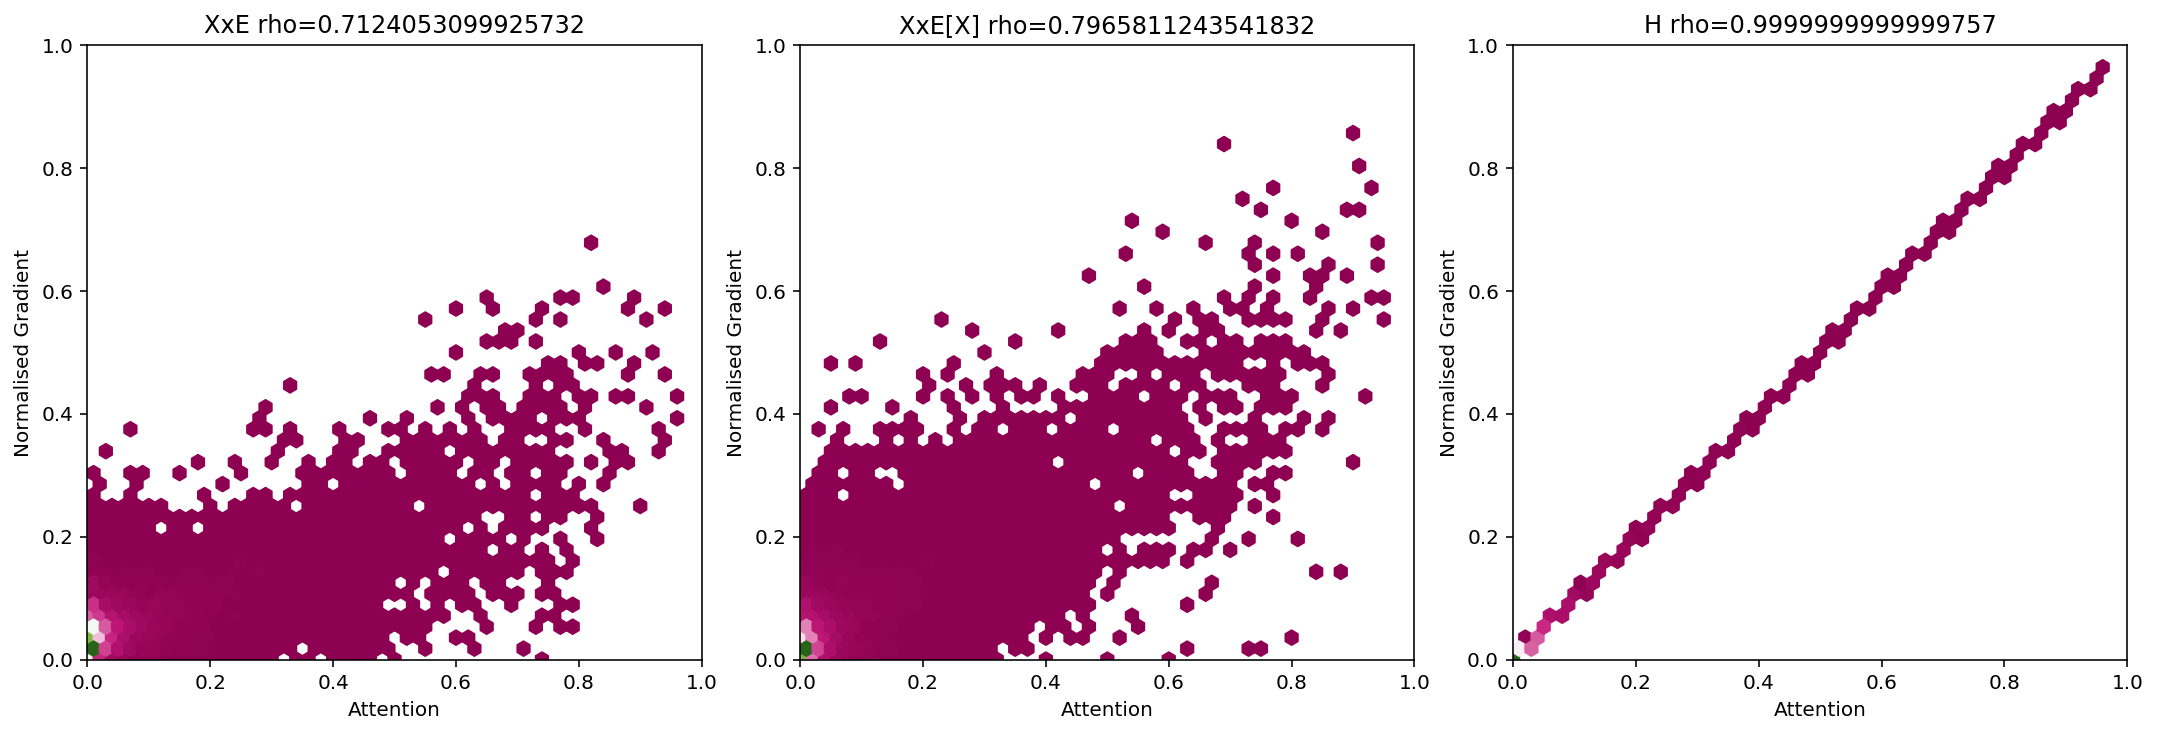

In [77]:
plot_grads(Xt, attn_hat, grads, dirname=model.dirname)

**Permutation**
===========

In [78]:
perms = model.permute_attn(Xt)

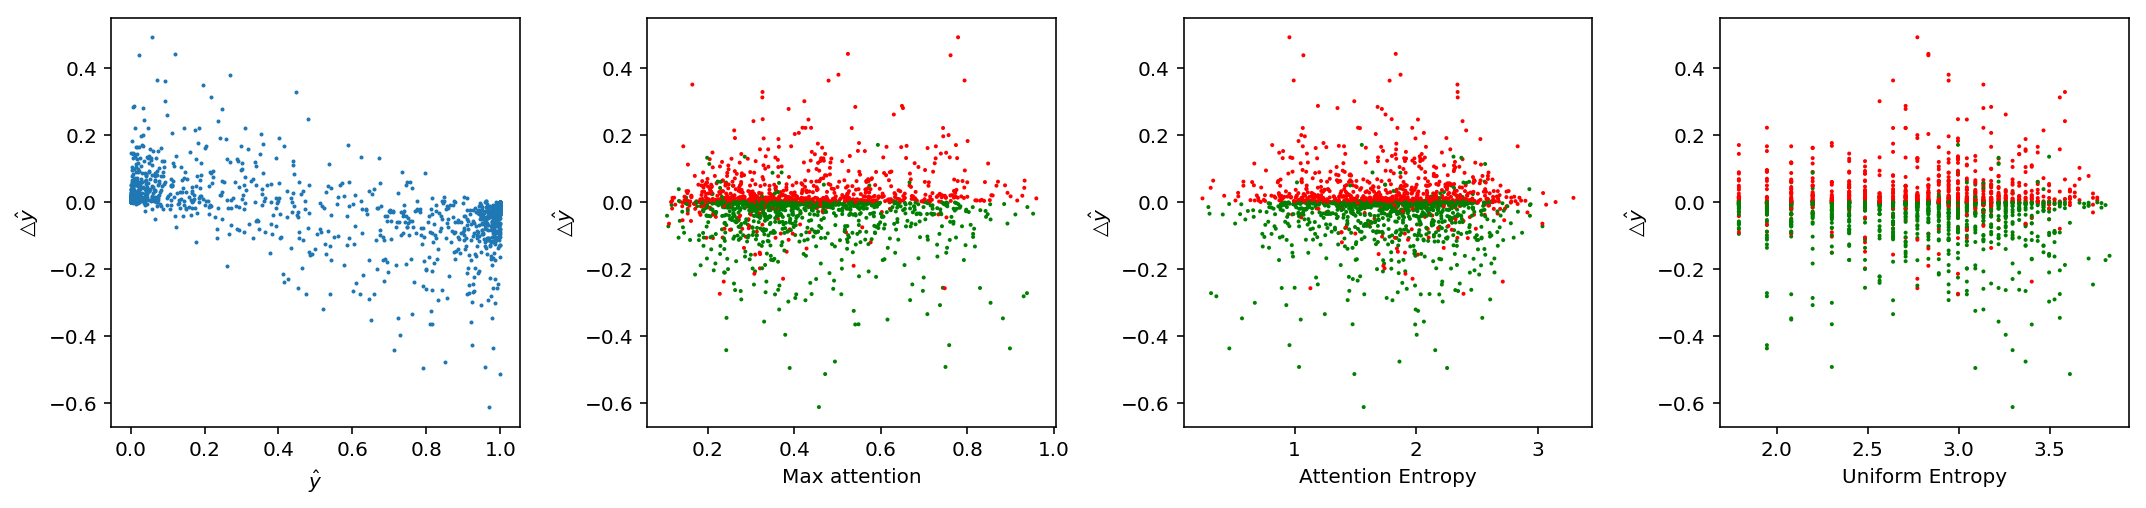

In [80]:
plot_permutations(perms, Xt, yt_hat, attn_hat, dirname=model.dirname)

**Adversarial Attention**
=========================

In [81]:
adversarial_outputs = model.adversarial(Xt, _type='uniform')
ad_y, ad_attn = adversarial_outputs

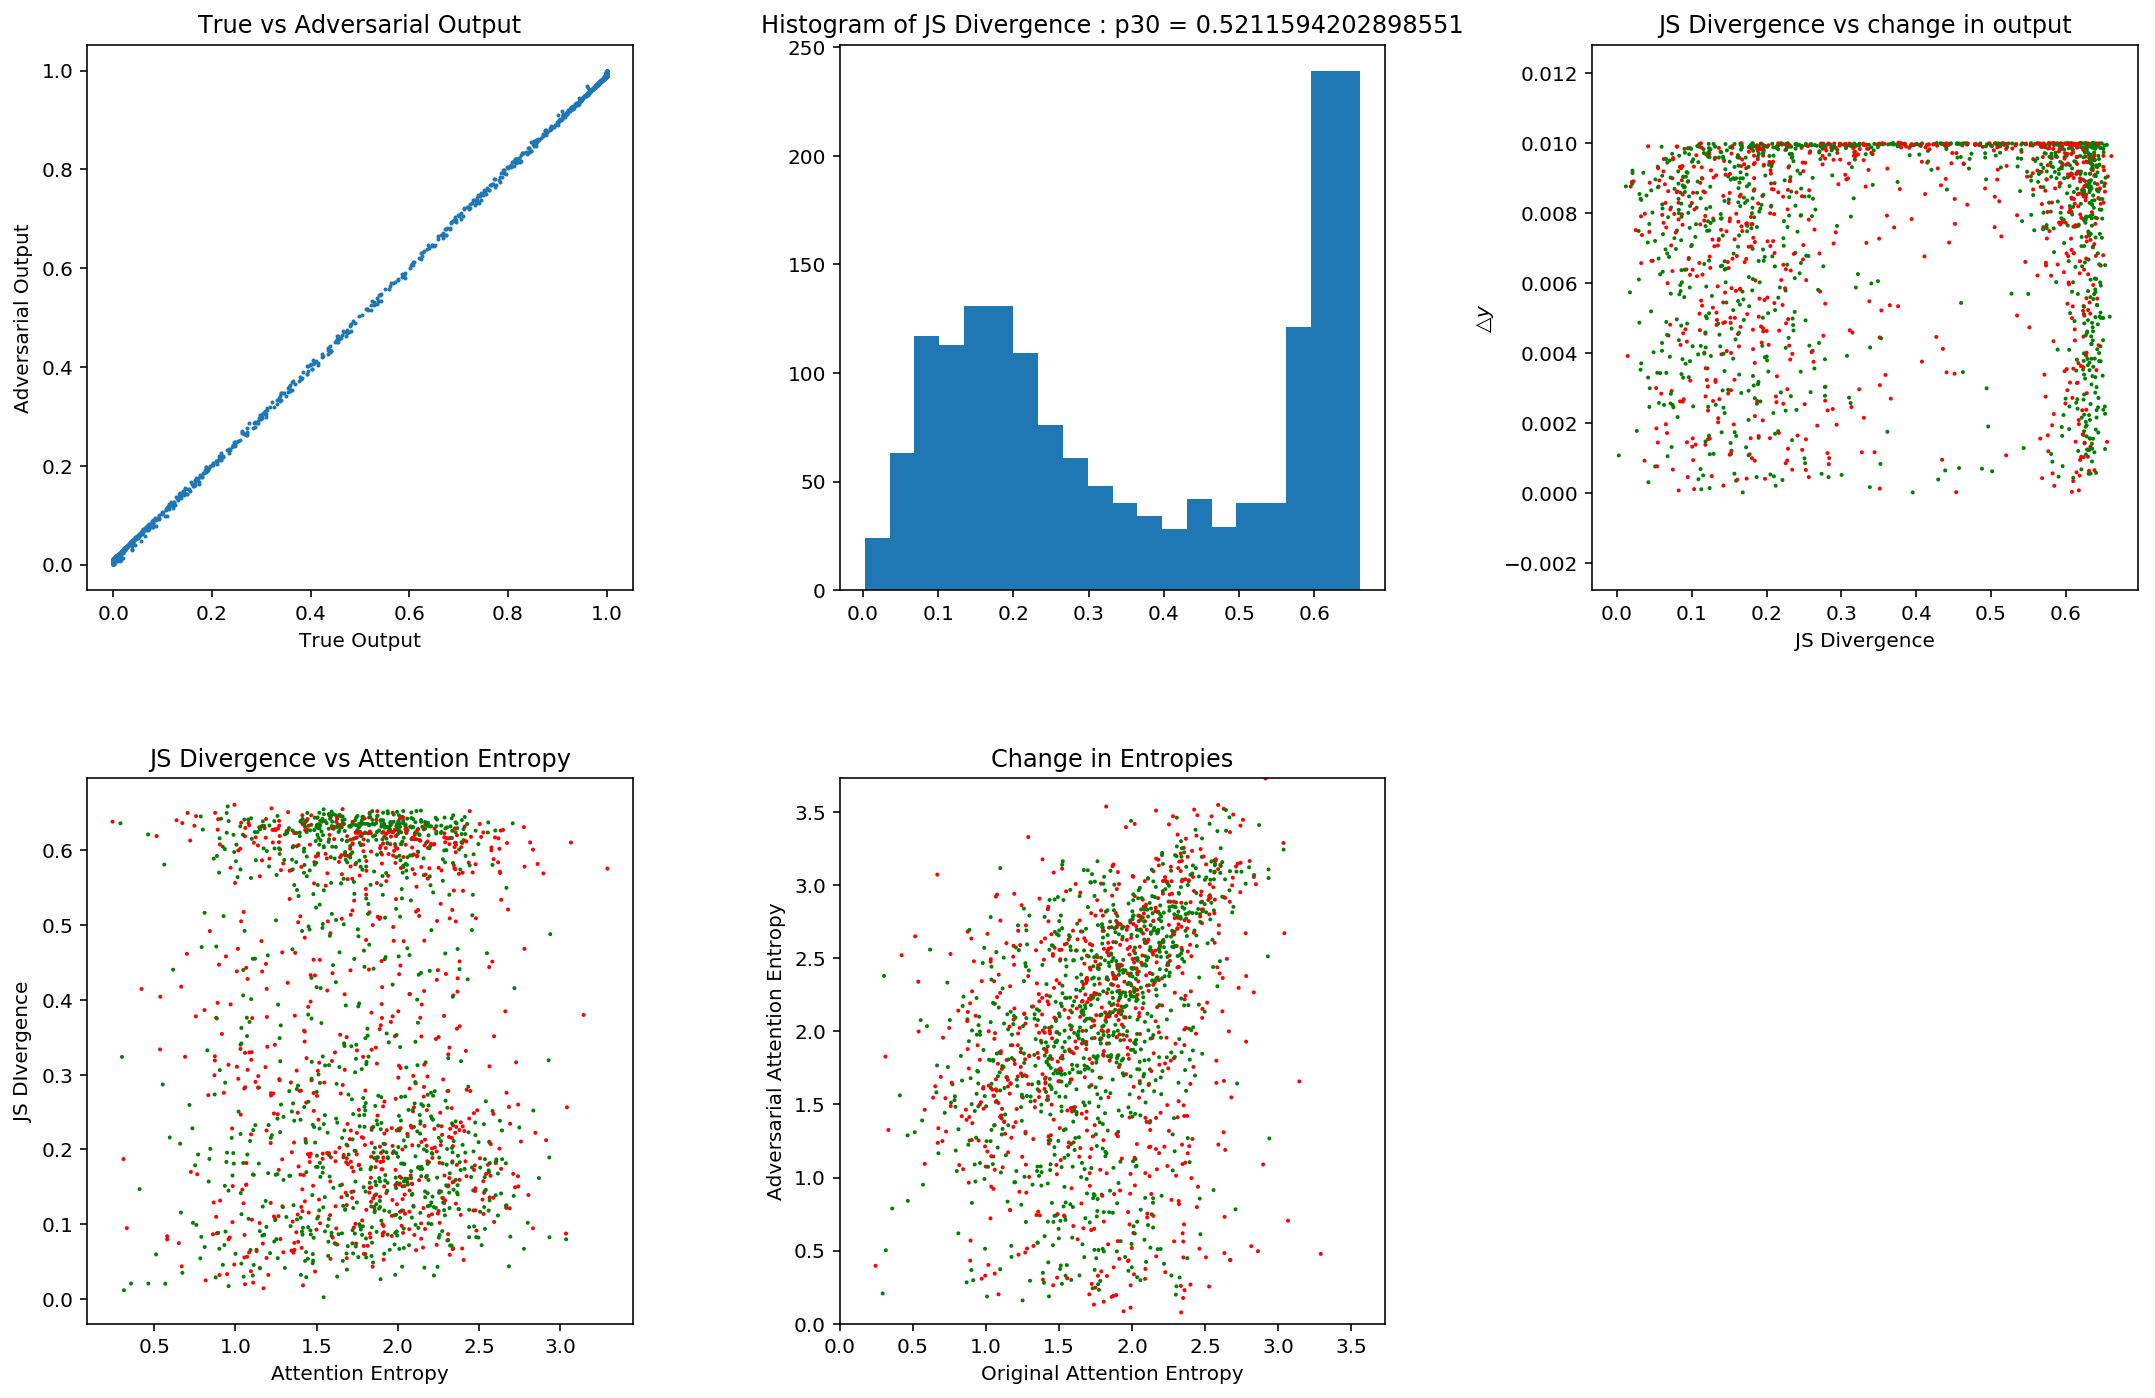

In [82]:
jds = plot_adversarial(Xt, yt_hat, attn_hat, adversarial_outputs, dirname=model.dirname)

In [50]:
idx = list(np.where(np.logical_and(np.array(jds) > 0.5, yt_hat > 0.7))[0])[:30]
idx

[4,
 5,
 10,
 15,
 26,
 28,
 30,
 36,
 38,
 39,
 42,
 44,
 45,
 51,
 54,
 56,
 61,
 63,
 66,
 70,
 75,
 76,
 79,
 87,
 88,
 98,
 100,
 103,
 112,
 113]

In [51]:
n = 113
print_adversarial_example(vec.map2words(X[n]), attn_hat[n], ad_attn[n])
print(yt_hat[n], ad_y[n])

--------------------


0.9965953 [0.98659766]


**Zero Runs** -- p(y|x, c) - p(y|x)
=============

In [83]:
zero_runs = model.zero_H_run(Xt)

In [84]:
zero_outputs, zero_H_diff = zero_runs

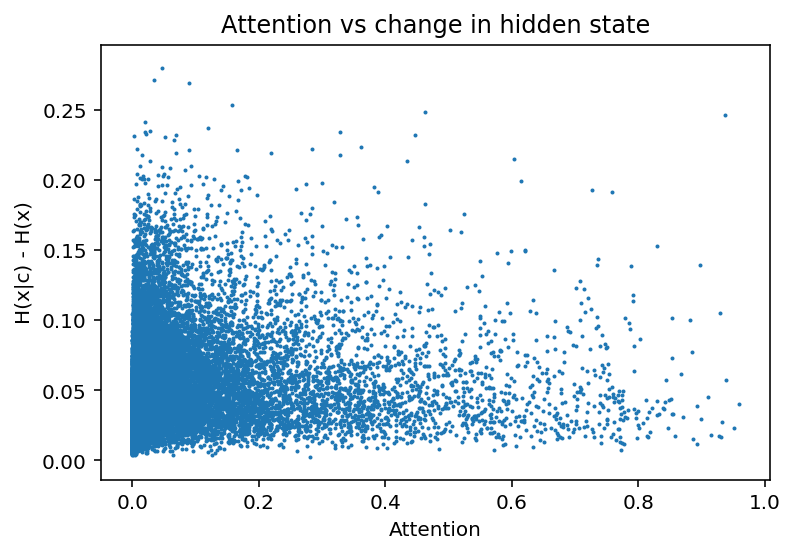

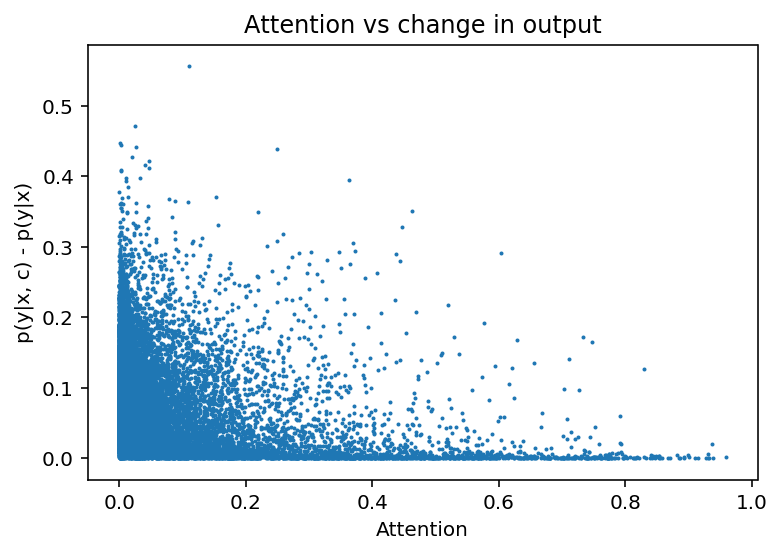

In [88]:
plot_attn_diff(Xt, attn_hat, zero_H_diff, xlabel='Attention', ylabel="H(x|c) - H(x)", 
               title="Attention vs change in hidden state", save_name="hxc-hx.pdf", dirname=model.dirname)
plot_y_diff(X, attn_hat, yt_hat, zero_outputs, xlabel="Attention", ylabel="p(y|x, c) - p(y|x)", 
            title="Attention vs change in output", save_name="pyxc-pyx.pdf", dirname=model.dirname)

**Remove and Run** -- p(y|x, c) - p(y|c)
==================

In [86]:
remove_outputs = model.remove_and_run(Xt)

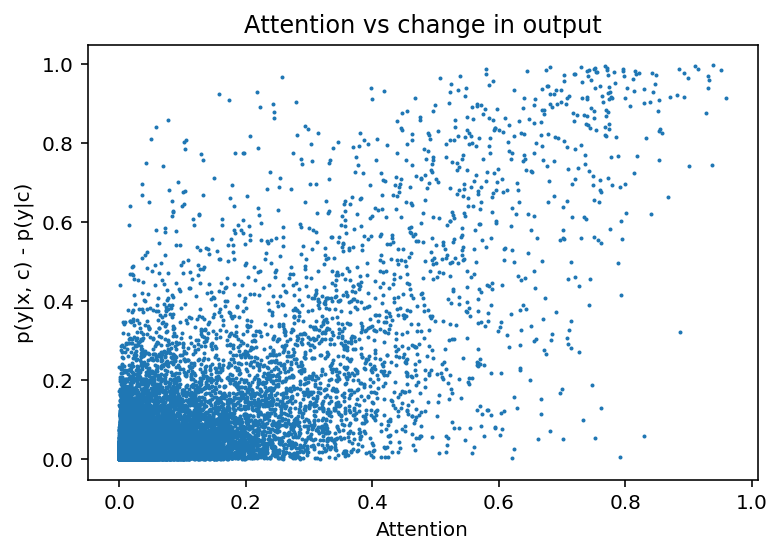

In [89]:
plot_y_diff(Xt, attn_hat, yt_hat, remove_outputs, xlabel="Attention", ylabel="p(y|x, c) - p(y|c)", 
            title="Attention vs change in output", save_name="pyxc-pyc.pdf", dirname=model.dirname)

**Perturbation**
================

In [90]:
perturb_outputs = model.perturbation_embedding(Xt)

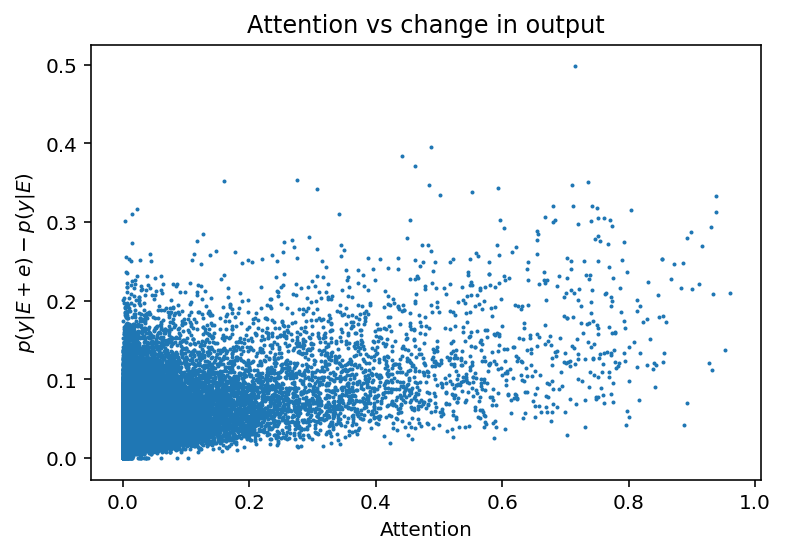

In [91]:
plot_pertub_embedding(Xt, attn_hat, yt_hat, perturb_outputs, dirname=model.dirname)